In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import requests
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
api_key = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
from scipy.stats import kurtosis, skew
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError

In [2]:
df = pd.read_csv('cisnes_negros_con_precios_open_close_Full_df.csv')
df['expiration_str'] = df['expiration_str'].astype(str).apply(lambda x: x[2:])

In [3]:
df

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,weekly_expiration,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,expiration,expiration_str,open_price,close_price
0,2,AVGO,NaN,2025-06-10 20:00:00,2025-06-10,3,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-13,250613,NaN,NaN
1,2,AVGO,NaN,2022-09-01 20:00:00,2022-09-01,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,9.56,9.73,0.02,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-02,220902,NaN,NaN
2,2,AVGO,NaN,2022-12-08 21:00:00,2022-12-08,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,10.28,10.45,0.02,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-09,221209,NaN,NaN
3,2,AVGO,NaN,2023-03-02 21:00:00,2023-03-02,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,10.10,10.33,0.02,0.23,cisne_blanco,59.58,60.75,0.22,0.55,2023-03-03,230303,NaN,NaN
4,2,AVGO,NaN,2023-08-31 20:00:00,2023-08-31,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.8,2.99,2.2,1.42,2.03,0.0,4.3,8.0,10.42,10.54,0.01,0.42,cisne_blanco,92.29,90.19,0.79,0.74,2023-09-01,230901,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,554,ZTS,NaN,2025-02-11 13:00:00,2025-02-10,9,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-19,250219,NaN,NaN
6506,554,ZTS,NaN,2025-04-30 12:00:00,2025-04-29,15,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-14,250514,NaN,NaN
6507,554,ZTS,NaN,2022-11-03 11:00:00,2022-11-02,14,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.24,1.21,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-16,221116,NaN,NaN
6508,554,ZTS,NaN,2024-05-02 11:00:00,2024-05-01,14,0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.34,1.38,0.03,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-15,240515,NaN,NaN


In [4]:
df = df[df['gap_before_close'].notna()]
print(len(df))

684


In [5]:
# Calculate strike_put
df['strike_put'] = df.apply(lambda row: row['gap_before_close'] - row['mean_gap'], axis=1)
df['strike_put'] = df['strike_put'].fillna(0)
df['strike_put'] = df['strike_put'].apply(np.floor).astype(int)

# Calculate strike_call
df['strike_call'] = df.apply(lambda row: row['gap_before_close'] + row['mean_gap'], axis=1)
df['strike_call'] = df['strike_call'].apply(np.ceil)

# Fill NaN values with 0 and then convert to integers
df['strike_call'] = df['strike_call'].fillna(0).apply(np.floor).astype(int)

# Format strike_put
def format_strike_put(value):
    return f"{int(value):05d}000"
df['strike_put'] = df['strike_put'].apply(format_strike_put)

# Format strike_call
def format_strike_call(value):
    return f"{int(value):05d}000"
df['strike_call'] = df['strike_call'].apply(format_strike_call)

In [6]:
df

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,weekly_expiration,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,expiration,expiration_str,open_price,close_price,strike_put,strike_call
3,2,AVGO,NaN,2023-03-02 21:00:00,2023-03-02,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.10,10.33,0.02,0.23,cisne_blanco,59.58,60.75,0.22,0.55,2023-03-03,230303,NaN,NaN,00058000,00061000
4,2,AVGO,NaN,2023-08-31 20:00:00,2023-08-31,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.42,10.54,0.01,0.42,cisne_blanco,92.29,90.19,0.79,0.74,2023-09-01,230901,NaN,NaN,00091000,00094000
5,2,AVGO,NaN,2023-12-07 21:00:00,2023-12-07,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.98,11.06,0.01,0.04,cisne_blanco,92.10,92.28,0.41,0.56,2023-12-08,231208,NaN,NaN,00091000,00093000
6,2,AVGO,NaN,2023-06-01 20:00:00,2023-06-01,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.08,10.32,0.02,0.01,cisne_blanco,79.00,79.06,0.41,0.73,2023-06-02,230602,NaN,NaN,00078000,00080000
7,2,AVGO,NaN,2024-06-12 20:00:00,2024-06-12,2,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.84,10.96,0.01,4.29,cisne_negro,149.55,171.00,0.65,1.67,2024-06-14,240614,NaN,NaN,00148000,00151000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,365,KKR,NaN,2023-02-07 11:00:00,2023-02-06,3,1,"[2.7, 3.6, 0.3, nan, nan, 0.2, 0.8, 2.2, 0.8]",1.51,-1.28,0.49,1.32,1.74,0.2,3.6,7.0,0.86,0.92,0.07,1.16,cisne_blanco,55.85,57.01,1.12,3.70,2023-02-09,230209,NaN,NaN,00054000,00058000
4273,365,KKR,NaN,2023-05-08 10:00:00,2023-05-07,4,1,"[2.7, 3.6, 0.3, nan, nan, 0.2, 0.8, 2.2, 0.8]",1.51,-1.28,0.49,1.32,1.74,0.2,3.6,7.0,0.74,0.81,0.10,0.00,cisne_blanco,51.51,51.51,1.48,3.16,2023-05-11,230511,NaN,NaN,00050000,00054000
4283,366,KLAC,NaN,2023-01-26 21:00:00,2023-01-26,1,1,"[2.0, 3.5, 0.8, 3.5, 5.3, 4.8, 1.9, 1.6]",2.92,-1.28,0.24,1.60,2.57,0.8,5.3,8.0,7.10,7.38,0.04,3.48,NaN,425.38,407.98,2.52,3.04,2023-01-27,230127,NaN,NaN,00422000,00429000
4284,366,KLAC,NaN,2023-04-26 20:00:00,2023-04-26,2,1,"[2.0, 3.5, 0.8, 3.5, 5.3, 4.8, 1.9, 1.6]",2.92,-1.28,0.24,1.60,2.57,0.8,5.3,8.0,5.32,5.49,0.03,5.28,NaN,357.36,383.75,2.70,3.36,2023-04-28,230428,NaN,NaN,00354000,00361000


In [7]:
df

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,weekly_expiration,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,expiration,expiration_str,open_price,close_price,strike_put,strike_call
3,2,AVGO,NaN,2023-03-02 21:00:00,2023-03-02,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.10,10.33,0.02,0.23,cisne_blanco,59.58,60.75,0.22,0.55,2023-03-03,230303,NaN,NaN,00058000,00061000
4,2,AVGO,NaN,2023-08-31 20:00:00,2023-08-31,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.42,10.54,0.01,0.42,cisne_blanco,92.29,90.19,0.79,0.74,2023-09-01,230901,NaN,NaN,00091000,00094000
5,2,AVGO,NaN,2023-12-07 21:00:00,2023-12-07,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.98,11.06,0.01,0.04,cisne_blanco,92.10,92.28,0.41,0.56,2023-12-08,231208,NaN,NaN,00091000,00093000
6,2,AVGO,NaN,2023-06-01 20:00:00,2023-06-01,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.08,10.32,0.02,0.01,cisne_blanco,79.00,79.06,0.41,0.73,2023-06-02,230602,NaN,NaN,00078000,00080000
7,2,AVGO,NaN,2024-06-12 20:00:00,2024-06-12,2,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.84,10.96,0.01,4.29,cisne_negro,149.55,171.00,0.65,1.67,2024-06-14,240614,NaN,NaN,00148000,00151000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,365,KKR,NaN,2023-02-07 11:00:00,2023-02-06,3,1,"[2.7, 3.6, 0.3, nan, nan, 0.2, 0.8, 2.2, 0.8]",1.51,-1.28,0.49,1.32,1.74,0.2,3.6,7.0,0.86,0.92,0.07,1.16,cisne_blanco,55.85,57.01,1.12,3.70,2023-02-09,230209,NaN,NaN,00054000,00058000
4273,365,KKR,NaN,2023-05-08 10:00:00,2023-05-07,4,1,"[2.7, 3.6, 0.3, nan, nan, 0.2, 0.8, 2.2, 0.8]",1.51,-1.28,0.49,1.32,1.74,0.2,3.6,7.0,0.74,0.81,0.10,0.00,cisne_blanco,51.51,51.51,1.48,3.16,2023-05-11,230511,NaN,NaN,00050000,00054000
4283,366,KLAC,NaN,2023-01-26 21:00:00,2023-01-26,1,1,"[2.0, 3.5, 0.8, 3.5, 5.3, 4.8, 1.9, 1.6]",2.92,-1.28,0.24,1.60,2.57,0.8,5.3,8.0,7.10,7.38,0.04,3.48,NaN,425.38,407.98,2.52,3.04,2023-01-27,230127,NaN,NaN,00422000,00429000
4284,366,KLAC,NaN,2023-04-26 20:00:00,2023-04-26,2,1,"[2.0, 3.5, 0.8, 3.5, 5.3, 4.8, 1.9, 1.6]",2.92,-1.28,0.24,1.60,2.57,0.8,5.3,8.0,5.32,5.49,0.03,5.28,NaN,357.36,383.75,2.70,3.36,2023-04-28,230428,NaN,NaN,00354000,00361000


In [8]:
def fetch_option_data(df, base_url, api_key, ticker_column, expiration_str_column, option_type, strike_column, to_open_day_column, price_type):
    results = []
    close_prices = []
    open_prices_next_day = []
    
    for index, row in df.iterrows():
        try:
            # Extract parameters from the DataFrame row
            ticker = row[ticker_column]
            expiration_str = str(row[expiration_str_column])
            strike = str(row[strike_column])
            to_open_day = row[to_open_day_column]
            
            # Construct the full option symbol
            option_symbol = f'O:{ticker}{expiration_str}{option_type}{strike}'
            
            # Construct the full URL for the original day
            url = f"{base_url}/{option_symbol}/{to_open_day}?adjusted=true&apiKey={api_key}"
            print(f"URL for {price_type} close price: {url}")
            
            # Make the request to the Polygon API for the original day
            response = requests.get(url)
            
            # Check the status code and response for the original day
            if response.status_code == 200:
                data = response.json()
                close_price = data.get('close', None)
                close_prices.append(close_price)
                results.append(data)
            else:
                error_message = response.json()
                print(f"Error: {response.status_code}")
                print(error_message)
                close_prices.append(None)
                results.append(error_message)
            
            # Construct the date for the next day
            next_day = pd.to_datetime(to_open_day) + pd.Timedelta(days=1)
            next_day_str = next_day.strftime('%Y-%m-%d')
            
            # Construct the full URL for the next day
            url_next_day = f"{base_url}/{option_symbol}/{next_day_str}?adjusted=true&apiKey={api_key}"
            print(f"URL for {price_type} next day's open price: {url_next_day}")
            
            # Make the request to the Polygon API for the next day
            response_next_day = requests.get(url_next_day)
            
            # Check the status code and response for the next day
            if response_next_day.status_code == 200:
                data_next_day = response_next_day.json()
                open_price_next_day = data_next_day.get('open', None)
                open_prices_next_day.append(open_price_next_day)
            else:
                error_message_next_day = response_next_day.json()
                print(f"Error: {response_next_day.status_code}")
                print(error_message_next_day)
                open_prices_next_day.append(None)
        except Exception as e:
            print(f"An error occurred for row {index}: {e}")
            close_prices.append(None)
            open_prices_next_day.append(None)
            results.append({"error": str(e)})
    
    # Add the close_prices and open_prices_next_day to the DataFrame
    df[f'precio_compra_{price_type}'] = close_prices
    df[f'precio_venta_{price_type}'] = open_prices_next_day
    return results

# Define the base URL and API key
base_url = 'https://api.polygon.io/v1/open-close'
api_key = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'

# Fetch Put option data for all rows in the DataFrame
put_results = fetch_option_data(df, base_url, api_key, 'ticker', 'expiration_str', 'P', 'strike_put', 'to_open_day', 'Put')

# Fetch Call option data for all rows in the DataFrame
call_results = fetch_option_data(df, base_url, api_key, 'ticker', 'expiration_str', 'C', 'strike_call', 'to_open_day', 'Call')


URL for Put close price: https://api.polygon.io/v1/open-close/O:AVGO230303P00058000/2023-03-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1d9ac7ba772155277d6b7ef85619c183', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:AVGO230303P00058000/2023-03-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9773fc4ba2323b8c2ca6cb07be734ffc', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:AVGO230901P00091000/2023-08-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '57895200a486f83d262aed99bd29715e', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:AVGO230901P00091000/2023-09-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'req

Error: 404
{'status': 'NOT_FOUND', 'request_id': '2eefd55ac023bb1449e6deb1e9bebbda', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:DECK240215P00766000/2024-02-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'fdae4907a671c9092a1ab7807f72a135', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:DECK240215P00766000/2024-02-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '3bdeebe9c5a7f493b5e3218a19d133e9', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:GOOG230428P00103000/2023-04-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:GOOG230428P00103000/2023-04-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put close price: https://api.po

Error: 404
{'status': 'NOT_FOUND', 'request_id': '053a765a0edf92f61f3a3dbd828fbcd7', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:IDT240314P00000000/2024-03-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '4d4671112e0081171d08511f149e382d', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:JCI230816P00069000/2023-08-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6fa548cc765fc2508681a97335d7b824', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:JCI230816P00069000/2023-08-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cb7ff0c3e9971ab765ebe6664812acbb', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:JCI231213P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': '57a330866e538d462afabc2fb3d24b16', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:J240214P00137000/2024-02-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1ac094ad8b22d023960541bc220531ff', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:J240515P00148000/2024-05-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9fe714b2ba07d62dc8c228b0e63a4757', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:J240515P00148000/2024-05-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '5417450744e0f58d70dc3a3cc3306673', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:ADBE230317P0032500

Error: 404
{'status': 'NOT_FOUND', 'request_id': '4d7d0a3193abaf90db94d55e32f30db6', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:JBL231213P00119000/2023-12-14?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '083fab82b45398d70c8129c6ea1c69f3', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:JBL240417P00146000/2024-03-14?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9ac999496d374edaa47a53b294be3e8f', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:JBL240417P00146000/2024-03-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '970f47146d8a64bf3f89a12eda43e10a', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:AAP230614P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': '814fcef09268370fa2b94e2a6e5b812f', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:LANC240515P00190000/2024-05-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '02df79a1b4d4bd10c6c7f2b0854d1c77', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:LANC240515P00190000/2024-05-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '3b98d970cc86db4ce3bf077c8a73b561', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:DOLE230315P00011000/2023-03-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '767647fc01e637c7089a575f34a3d31b', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:DOLE23031

Error: 404
{'status': 'NOT_FOUND', 'request_id': '8557f2ed29b764e51b3e498ed66389d4', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:KAI230518P00185000/2023-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'c9d64f886d0c38a909875520a509ea76', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:KAI230817P00222000/2023-08-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '75d3df8bf679c497f5d5a6c85dbc98b9', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:KAI230817P00222000/2023-08-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ca723ff257642b823a8da7680f9fb5ce', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:KAI240215P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b8bb0d1dc077f48ad50740d4132fd86b', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:AAPL240503P00171000/2024-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a2922037b76f018485c77364255db4ee', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:T230126P00018000/2023-01-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bc69a9f578a43e8d0c596424fe4e4d78', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:T230126P00018000/2023-01-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'aa1ce3787037e0599047c28f3ea7f344', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:T240425P0001500

Error: 404
{'status': 'NOT_FOUND', 'request_id': '31c9d0ad9cad0282327fefa311353340', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:MCHP230216P00082000/2023-02-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f5b14dceec68578c3bdf77c75066c2be', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MCHP230216P00082000/2023-02-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f76c5939d66df0883de6c8ccfff5d329', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:MCHP230518P00075000/2023-05-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '3d45cbe0e2153a5ba5586a0207965ea3', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MCHP23051

Error: 404
{'status': 'NOT_FOUND', 'request_id': '738b99abd022104d589c7e02b18d72a1', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MCRI240215P00068000/2024-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2d9e119c1a4c8630b630340f4e316931', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:MCRI240418P00069000/2024-04-17?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'beb898e1f965de44c962d98ed952bf94', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MCRI240418P00069000/2024-04-18?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '437b5fb3e39f7a53e057c40b4f1a8203', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:PEP230209

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'dffb1d998a8533150c28d7bda8a597e2', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:MS240418P00084000/2024-04-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2279eb6350940c5602a6a0311bb8cd3f', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MS240418P00084000/2024-04-16?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '42551ad46f89244ce139b4042678f987', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:NTAP230825P00070000/2023-08-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:NTAP230825P00070000/2023-08-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put close price: https://api.polygo

Error: 404
{'status': 'NOT_FOUND', 'request_id': '0c213438fddb4aba9ba1c3ac6d6e2fc1', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CRM240531P00268000/2024-05-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '3f88596ab9682834983c1eb86b61e398', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CRM240531P00268000/2024-05-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '08c318f20ed465f74ee35f6007a11d01', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CRM240301P00295000/2024-02-28?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CRM240301P00295000/2024-02-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put close price: https://api.polygo

Error: 404
{'status': 'NOT_FOUND', 'request_id': '1eb2a551b25c0e1cd46232b8fff9f42a', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:TNK230816P00043000/2023-08-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '814b09e3e070add80321ea57169ecc4e', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:TNK230816P00043000/2023-08-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '3e717e26c5ac09948d9570775a6ca44c', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:TNK231115P00051000/2023-11-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '929f1ff2b2efac84daad86f30d1258e7', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:TNK231115P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': '2556bf0e64a0bffd3c13de51152c0654', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:TSLA230721P00288000/2023-07-20?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a336f74781c01c38c2bf80600a33fbde', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:SQM230315P00087000/2023-03-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '7c9c8d95019f7fe294aae794b43381c1', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:SQM230315P00087000/2023-03-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ccc5cf87e5a5bc35927ee0fe1ad916ab', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:SQM230517P0

Error: 404
{'status': 'NOT_FOUND', 'request_id': '6d8c6d3fa487ee3fbca76f2c459eb846', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:EME231115P00190000/2023-10-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '8a6cfc4c80b86f614b3fff4b560509df', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:EME230816P00187000/2023-07-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '84e0b2fb4b3b0ab29ea0737528310235', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:EME230816P00187000/2023-07-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ac8e94a365cf93dbe89b7c9a9a8bf9f6', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:FDX230317P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b54ba8c2df5d657c90d73bf5046eb5cf', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:C240411P00059000/2024-04-11?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'aec364653d6987a9abfe606207b10159', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:C240411P00059000/2024-04-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bc5223b432ccc56f059bb4195d031c30', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:MCD240502P00272000/2024-04-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '07078cd3b6dc047dfc6e7600ceb3a139', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MCD240502P002720

Error: 404
{'status': 'NOT_FOUND', 'request_id': '0028a37cef93b75de46377f8e2480995', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MCK230512P00366000/2023-05-09?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6208451156d5e65768351d31dccaffe0', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:MCK230804P00411000/2023-08-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '463b2b396252493f80c8e2937a3517c0', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:MCK230804P00411000/2023-08-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bbf273c6f59af5773550fa086aaf6167', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:UUUU230316P0

Error: 404
{'status': 'NOT_FOUND', 'request_id': '95a57be1c36eebf203538bf3bdd15b7a', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:GSHD240815P00064000/2024-07-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '621b398fceee3031db64c53c4173ed89', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:GGG240215P00084000/2024-01-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'eff391281b4ecb9b43b226c2bd3f9e5e', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:GGG240215P00084000/2024-01-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '202a4908daee489ea63980090a3096d5', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:GGG240516P0

Error: 404
{'status': 'NOT_FOUND', 'request_id': '3e4b9260c3d8a9709532933d134675da', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:APD231115P00289000/2023-11-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '46b0352b330a2dd6df784bd8434e8080', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:APD240214P00258000/2024-02-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '06bf29a83e5d62f05dd2da7d86aa7228', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:APD240214P00258000/2024-02-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '58b304cb1316e37aea2d34dcd21f4f42', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:ABNB230804P0

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ba43c550674063661f8d923bbb7377d6', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:AMCR230518P00010000/2023-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd6ec5ead78962c59b63c5803e183a1e9', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:AEE230216P00085000/2023-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'c479ccc56ccd5a6fec4633f3e40c8f5c', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:AEE230216P00085000/2023-02-16?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd7efd5380a11738d372d58b156310fb1', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:AEE230518P0

Error: 404
{'status': 'NOT_FOUND', 'request_id': '577354a50a4b23f1b17041b06291c3c9', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:AMGN230203P00248000/2023-01-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ebbbac8c0cb4de07f9513790f802663a', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:AMGN230203P00248000/2023-02-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '132226b4be324188df726cda945ddbd9', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:APH230215P00039000/2023-01-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '956eebfbd4d2fc24f3776ee1a2a13d82', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:APH230215P

URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:ANET231103P00170000/2023-10-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put close price: https://api.polygon.io/v1/open-close/O:AJG230817P00216000/2023-07-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '5a30582513c42be018795b26d158fbe3', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:AJG230817P00216000/2023-07-28?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b9d0fcc2a3ad6b2676c3c762c5e71e0d', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:AJG231116P00229000/2023-10-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9409a26cadbd138f54b7ade80281a0b3', 'message': 'Data not found.'}
URL for Put next day's open price: https:/

Error: 404
{'status': 'NOT_FOUND', 'request_id': '01f84700bf92b429e3ae8f8466130a87', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:BKR230215P00029000/2023-01-22?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a7fc1cd7f298fff0ad14c05f11b62c4a', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:BKR230215P00029000/2023-01-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '574e873a0dbd9cfd4b1519db51a24004', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:BALL240515P00064000/2024-04-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0f0776c4e28830d87c96a07059657f9c', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:BALL240515P

Error: 404
{'status': 'NOT_FOUND', 'request_id': '8d2eda1d93e322ff154b049631308355', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:BLK240411P00784000/2024-04-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '5ca26723fd6e266220ccb6e4221b5fa2', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:BX240125P00118000/2024-01-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '04a5d9b64c23bb761b7eefdb740e967d', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:BX240125P00118000/2024-01-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0f3af97d2ba09f94bf8305d02f86c1de', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:BX240418P00121

Error: 404
{'status': 'NOT_FOUND', 'request_id': '306cc3f3305e52c4ab62c1a80458432b', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:BG240214P00089000/2024-02-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '5fedc4a82e45985ff223ab80c5b2e701', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:BG240214P00089000/2024-02-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cdec71b773da6a66d1e687bdbb1180a3', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:BXP230817P00064000/2023-08-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6f929698ccffda738871102e8ade7ab8', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:BXP230817P0006

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b72c6bf68f190bd4e49b303cd3192a15', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CARR230518P00041000/2023-04-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e4d161aa2c88c187b574adcee6844ee8', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CARR230518P00041000/2023-04-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2332fcdb00978d69fec7c164cd3029a0', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CARR230215P00045000/2023-02-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6cfa81fbadf6d92bc082a5ced61c8c30', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CARR23021

URL for Put close price: https://api.polygon.io/v1/open-close/O:CHRW230216P00099000/2023-02-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e59fdee50ca7531a5e0519e19ef1d758', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CHRW230216P00099000/2023-02-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ba542df54938825545c99c28ac9a2f08', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CRL240515P00234000/2024-05-08?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'fc77ba15662511c70922429c13656ffc', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CRL240515P00234000/2024-05-09?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'reque

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f5a9a40816f80a61f375d960e4e7adbe', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CINF230518P00103000/2023-04-28?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'dc57e5e71739589e41b6c4db010be74b', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CTAS230419P00441000/2023-03-28?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a3c36368878e5b02e1ddca98ba62a17f', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CTAS230419P00441000/2023-03-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6ee2a9042161c01a0276f2e42f4edbfd', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CFG240717

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'dbf969284c89b736bd7fce77499ddb2e', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:ED240516P00095000/2024-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '273f87cdce04dcfad1f614bbcfd386dc', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:STZ240704P00257000/2024-07-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9f6a0821bf62ddc360b68975897faddf', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:STZ240704P00257000/2024-07-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '880c06d61000cdcfddbd7a88fa9d25aa', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:STZ240411P002

Error: 404
{'status': 'NOT_FOUND', 'request_id': '04436686bb735e1f44eb3ac00a0ca871', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CRWD240607P00301000/2024-06-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '94a087a7fd17287523a65873260a1673', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CRWD240607P00301000/2024-06-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '3a5c9963c6be60a49ad6e276eb7bb806', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:CCI231019P00090000/2023-10-18?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '265373e5415a7f392c01e77d80198751', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:CCI231019P

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b596e99ca03e960bd369715b280cc84a', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:DXCM231027P00073000/2023-10-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6bd447466b990cf70c4cc64a673bc8d8', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:DXCM240209P00119000/2024-02-08?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:DXCM240209P00119000/2024-02-09?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put close price: https://api.polygon.io/v1/open-close/O:FANG230804P00146000/2023-07-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '51e8b75d8b40a8169925ac5e1de26e61', 'message': 'Data not found.'}
URL for Put next day's open price: http

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bb88b6d51fe267b37cbd2d519963a677', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:DHI240125P00155000/2024-01-22?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '374d0679702a4767b670ab0ca388f1b6', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:DHI240125P00155000/2024-01-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '58b646d2e8551d882e186eca352eeccd', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:DHI240418P00143000/2024-04-17?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'fd4e477c71153a9d12622a792f4012c9', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:DHI240418P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': '26de1e1ebdfa3d2b2ff45c6d8bee5c12', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:EW240815P00085000/2024-07-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '4c31d129ef9273b1760f670aee503d35', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:EA240510P00125000/2024-05-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:EA240510P00125000/2024-05-08?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Put close price: https://api.polygon.io/v1/open-close/O:ELV240717P00551000/2024-07-16?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '27c46fea15c8ec0031cb32bdd3d601b9', 'message': 'Data not found.'}
URL for Put next day's open price: https://api

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b7a1dd3884daeb37c6426310f00bd8e6', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:EQR240215P00059000/2024-01-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '5ad92e651592da13a2b783bdb38be099', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:EQR240215P00059000/2024-01-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f893e34f534389abfb39cfd9fe9d6650', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:ESS230518P00211000/2023-04-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd1309bc94074ffd1324f632184f09450', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:ESS230518P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f35d611865e7b554bc1a561e9530e769', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:FDS240117P00456000/2023-12-19?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2bcacc51b01a57130d90fd01358c467a', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:FAST231018P00055000/2023-10-11?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd279f23ebc2b02bd8318b26d86a66a4a', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:FAST231018P00055000/2023-10-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b3213333cbcebc42922960a50006fd51', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:FAST230719

Error: 404
{'status': 'NOT_FOUND', 'request_id': '03ead42b7a1e5d44af4882beaecc8497', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:FTV230517P00064000/2023-04-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f513aee7f114096c531da7cae2a8289a', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:FTV230517P00064000/2023-04-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ee0554e2eee2220ed95c3a6fdb67b424', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:FOXA230209P00032000/2023-02-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'c03c6a2443221b41ffcd7424f8a902ae', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:FOXA230209P

Error: 404
{'status': 'NOT_FOUND', 'request_id': '0f43563db6b52a3a6137731fb11cd042', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:GNRC230504P00099000/2023-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f82a3429d44aeda8f6949cad584ceb90', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:GNRC230216P00120000/2023-02-14?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ca392d6457196b970722824c500ecf7a', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:GNRC230216P00120000/2023-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '4af71f837041ce69336c75be844e612a', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:GIS230323

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e0948f2601611bf12c04fd699ef148d8', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:HAS231115P00053000/2023-10-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '15dc26d6b9dc846549ffcc423fd580d7', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:HCA230517P00267000/2023-04-20?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '948903eef57a0639502f6d38b67c1209', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:HCA230517P00267000/2023-04-21?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '7ac32974bd591ed2fcfe08423e2cd2f3', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:HCA230816P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f9bc5056fd913d222f9dc3ba11d251ae', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:HON240425P00192000/2024-04-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd18cbd46616b65893a878f0ae38095e9', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:HON240425P00192000/2024-04-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '4a727f89a06e8ca43bb4ce717f53175a', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:HRL240229P00028000/2024-02-28?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '4ef871bc455c718c3b1c3351997170fe', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:HRL240229P00

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e27e1f8c58a68a271c91921c9ca29f65', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:INCY240515P00051000/2024-04-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e88d7fcb7fdea6cd205b535d7461f13b', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:IR231116P00061000/2023-11-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '010d730a3a979a362b5d10b26a8b37f3', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:IR231116P00061000/2023-11-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a366b5f55cfbd7677fec0d54f7dc371f', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:IR240215P0008

Error: 404
{'status': 'NOT_FOUND', 'request_id': '85c4b7ac4c325f07de367f8fb44d1b28', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:INVH240815P00035000/2024-07-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e6618bdcd05a68ab688dbc85bb768f76', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:INVH240815P00035000/2024-07-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b7949a665fb62b6573f8a8ae01cc98a8', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:IQV240214P00212000/2024-02-13?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '017c8ad4dfd5cfc0ac863fca0ef35b58', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:IQV240214P

Error: 404
{'status': 'NOT_FOUND', 'request_id': '724971fa4da3ae2f52dd5ea6c6a14fac', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:KEY240418P00013000/2024-04-18?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd74f05e83bc8d1fcb357baf671ecf5a5', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:KEY240718P00015000/2024-07-17?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '3e68d0a8e5ec089398f216c1bb91d182', 'message': 'Data not found.'}
URL for Put next day's open price: https://api.polygon.io/v1/open-close/O:KEY240718P00015000/2024-07-18?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cb9b7fd7b23fec929f3f4c8f05f950d7', 'message': 'Data not found.'}
URL for Put close price: https://api.polygon.io/v1/open-close/O:KEYS231214P0

Error: 404
{'status': 'NOT_FOUND', 'request_id': '78b6aa4d7d04786193aaf0e36ddb4fe8', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AVGO230602C00080000/2023-06-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'fdf3a5c27aaaf4a1c40853d6f9655884', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AVGO230602C00080000/2023-06-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'c4eb0a0958fc7cbce270efa04055557a', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AVGO240614C00151000/2024-06-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'db73027f023aff3e7475247f107053b0', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AVGO2

URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:GOOG240426C00160000/2024-04-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:GOOG240726C00186000/2024-07-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '83c8aafef227a6b1948130c645ae005e', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:GOOG240726C00186000/2024-07-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '11de900191b3508adc7030af02704c4a', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:MO230803C00046000/2023-07-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bb03f55222f2cdcd2742e86d1f6e35b3', 'message': 'Data not found.'}
URL for Call next day's open price: h

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a0f50864363205749ac3c3ef43856084', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:JCI240214C00057000/2024-01-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '641c1d2eaa92077a2df506e3b099b022', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:JCI230517C00059000/2023-05-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cef04ffd898265f0bc0f3dcb6dd3cb8d', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:JCI230517C00059000/2023-05-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '04f5ed8224409cdbf5c8f2679e75bd7d', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:INSW2303

Error: 404
{'status': 'NOT_FOUND', 'request_id': '32583e2774196bc7bbb8f1409f9328c5', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:ADBE230915C00560000/2023-09-14?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:ADBE230915C00560000/2023-09-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:ADBE231215C00631000/2023-12-13?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'c2f6857b16306cfa6e2fa2770419ca70', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:ADBE231215C00631000/2023-12-14?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2f71946a0e43d21a04ad77e4e87a060e', 'message': 'Data not found.'}
URL for Call close price: https://a

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'dc20ba9a1313f4bce6893a776f964dd4', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AAP230614C00124000/2023-05-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ccefaf6c94ef0b26caca986ec0117f15', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AAP230913C00079000/2023-08-22?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '541d7cba1448f4fabfbbc30e54ba124f', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AAP230913C00079000/2023-08-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e3a517b9f003770b3ac2b8dcf52af426', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AAP24061

Error: 404
{'status': 'NOT_FOUND', 'request_id': '8f2e9c216cfd010d4a611c0b990e47f6', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:DOLE230517C00013000/2023-05-17?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '858c8653f072ae73dcd9dc67a7a76117', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:DOLE230517C00013000/2023-05-18?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bb64408e00eb08005e358c6e544ed8b7', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:DOLE231115C00012000/2023-11-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '47fd9794ad9dae01f9b3158f41375ed8', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:DOLE2

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f71106ceab82ca0d20e9ff3753c4e6b0', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:KAI240215C00315000/2024-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'c3b42ba0a919e033763260d148a28928', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:KAI240516C00275000/2024-04-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b62310624751a7ba2b22330dedeeaf12', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:KAI240516C00275000/2024-05-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0e53af6cfda3bef1e6a32d462c233f55', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:COP23080

Error: 404
{'status': 'NOT_FOUND', 'request_id': '542830e111df37226640b7e3d5babd70', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:T240425C00018000/2024-04-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1bf261557e54fe847e7ce3b739a7b69e', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:T240425C00018000/2024-04-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0e762d6361be171a3517c4a63eee6ded', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:T240125C00018000/2024-01-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '73a72725b3f928a25b97c178e32f17c2', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:T240125C000180

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'dd2f47be0a9008dae313249b5077a64b', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:MCHP230518C00077000/2023-05-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '229aab4feee3f1cdef81ba214f124d98', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:MCHP230518C00077000/2023-05-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '14de12d91d00c73999f550a8d07eabe2', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:PLTR240516C00028000/2024-05-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '4b79cb1d7ba5af20f9270bb52c85a283', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:PLTR2

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a76bce03dce68db376930e74d9295eaa', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:MCRI240215C00070000/2024-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e16bbb842dc0b34d65c06d1eaf6c14a0', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:MCRI240418C00071000/2024-04-17?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1c0b95eac0acfb876acd4816770e2c1a', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:MCRI240418C00071000/2024-04-18?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2a17054dfc66bd5a133e8a6451065508', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:PEP23

Error: 404
{'status': 'NOT_FOUND', 'request_id': '50c57ea89a3f38fa25badd4cacbf56c4', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:MS240418C00090000/2024-04-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '64f8f586eb200111574d368a1a8e1a3a', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:MS240418C00090000/2024-04-16?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '7869e9e1230a8db76e215976e2477627', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:NTAP230825C00083000/2023-08-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:NTAP230825C00083000/2023-08-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.p

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f5a2b64590d1a17d99c184156b3a72d2', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CRM240531C00276000/2024-05-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '80220441ee2b8d529d89c1d9eb5e04d7', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CRM240531C00276000/2024-05-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '4862ceaf2c8653ad0de340c02623c00d', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CRM240301C00303000/2024-02-28?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '39c3e05a092d0f897926c23f63287f43', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CRM24030

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a7930698357e46c7c6e8c12053d9aab1', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:TGT240307C00154000/2024-03-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '409fcfde9020125afc2668e041638540', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:TNK230816C00044000/2023-08-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ce3aff26abe56d98be5ed70b16884755', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:TNK230816C00044000/2023-08-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6c0b66cf1fd0a5af16847019ab54f545', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:TNK23111

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'daa4b0d181dceb1a58020cc92361fcf1', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:TSLA230721C00295000/2023-07-19?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:TSLA230721C00295000/2023-07-20?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:SQM230315C00089000/2023-03-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '6c27ffc1a88fe5ae9058b8c967cfc7ea', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:SQM230315C00089000/2023-03-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '5bcc1c24d3d6d52b50c4df670d42b007', 'message': 'Data not found.'}
URL for Call close price: https://api

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b49232e18043780e0d105c5b5e5c203e', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:EME231115C00193000/2023-10-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'e5420770ee388eff87d3ed3d3cd37002', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:EME230816C00190000/2023-07-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9d712f2c0cffdb63e8a2a67b95c27a96', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:EME230816C00190000/2023-07-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '99451af3a7e0a545a8110570717f6f7f', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:FDX23031

Error: 404
{'status': 'NOT_FOUND', 'request_id': '4b1ce96cbb7cd42e59a4fe648b47ced5', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:C240411C00062000/2024-04-11?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '51fc7c884be3e4d12effe7b6939c4614', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:C240411C00062000/2024-04-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2f86e4eee4a34535e0aa381d749c1e69', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:MCD240502C00275000/2024-04-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '8e5a0a88605285993cf90b7733497d60', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:MCD240502C00

Error: 404
{'status': 'NOT_FOUND', 'request_id': '5639855215195421e2e32a97aeb8186a', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:MCK230512C00371000/2023-05-08?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cb954000da90b584114a4cd3c7984a8c', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:MCK230512C00371000/2023-05-09?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '89d48a4309583d6d167e9a072c99fe07', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:MCK230804C00416000/2023-08-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '660375f58fadad8ebe0a32774bb12f04', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:MCK23080

Error: 404
{'status': 'NOT_FOUND', 'request_id': '25db33993739297e67277277ca4c4cb9', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:GSHD240815C00068000/2024-07-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '513c54499074f96b83421d65b4047872', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:GSHD240815C00068000/2024-07-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'be745da4ffc23dc6194752f421a67a1c', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:GGG240215C00086000/2024-01-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f5d4f8f164dc659f5841ebf722e86a65', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:GGG240

Error: 404
{'status': 'NOT_FOUND', 'request_id': '1c2c37948e68c86fc604719321584f4f', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:APD231115C00292000/2023-11-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '98bf691b4802d5a97d98b3e134f00959', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:APD231115C00292000/2023-11-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1694f4fe0f1a56fa07e4573a988a8701', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:APD240214C00261000/2024-02-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1268a65524b9d9b6e6e371b72211e3c9', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:APD24021

Error: 404
{'status': 'NOT_FOUND', 'request_id': '53377db6d4d5a4f078f35f1cba00caa0', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AMCR230817C00010000/2023-08-17?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ef95e403f3b8bfa374514a4c102da070', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AMCR230518C00012000/2023-05-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a55963ceb6d13e9afa719adda298f5d8', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AMCR230518C00012000/2023-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '422449f036b1bcd679143c3ed77ede61', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AEE23

Error: 404
{'status': 'NOT_FOUND', 'request_id': '916ffc0f11e07d6a9b1dee465a1468e9', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AME230215C00146000/2023-02-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '95b614b95416f3990181b321fe852a88', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AME230215C00146000/2023-02-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0ab6d7fcca9c5ae12ef2b3ae5ff0bb56', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AMGN230203C00255000/2023-01-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AMGN230203C00255000/2023-02-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api

URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:ANET230804C00160000/2023-08-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:ANET231103C00181000/2023-10-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '45c35a1e804346da15acbb8d0c89ecff', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:ANET231103C00181000/2023-10-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '2b728f7832d55c7bf147d621046089f8', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AJG230817C00218000/2023-07-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '98aeef9ed4eafd773d442d44d70d7172', 'message': 'Data not found.'}
URL for Call next day's open price: 

Error: 404
{'status': 'NOT_FOUND', 'request_id': '8eab567162226019962f99807a6473b3', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AXON230316C00202000/2023-03-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'eec3694f9ef16008e16037d4681af72a', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:AXON230518C00228000/2023-05-09?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9bd4391f34eb83cc52507944dd20b2d2', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:AXON230518C00228000/2023-05-10?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '67db6afcc6e44aab47d8e46c77a13a15', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:BKR23

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b39deb93b55742482a695d6807628edd', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:BLK240111C00794000/2024-01-11?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '12fd3b7fec102421b014e598a85e1bde', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:BLK240111C00794000/2024-01-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '955128d5f28a44fc992b90cc8eaaf0ae', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:BLK240411C00788000/2024-04-11?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1dad178e2d6ada769f93df62e6e2111c', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:BLK24041

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a61201a205cd68605eb207a7d32b624f', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:BLDR240515C00203000/2024-05-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '83dc7255f3ddb938ef164a60ef3effc8', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:BG231115C00103000/2023-10-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ac22373c0295b2c444e5625e208951f3', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:BG231115C00103000/2023-10-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '611bdbc2a7754b7b85734850494d0440', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:BG240214C

Error: 404
{'status': 'NOT_FOUND', 'request_id': '84025b76fa7d242c1242f7073c239893', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CCL230629C00017000/2023-06-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '59a9f17ed99c8e34c6e609ddce73a6cc', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CCL230629C00017000/2023-06-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '27b81bd022dcf5bb7f555888e0669d37', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CCL230330C00010000/2023-03-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd5231d211a4fd18da221e29d42b87057', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CCL23033

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cfd5e153f978bb09a3c4b446c814bc2e', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CNP231115C00028000/2023-10-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '81b1eb2d7d54ff3307974a77beed6bab', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CF230217C00087000/2023-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CF230217C00087000/2023-02-16?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:CF230505C00074000/2023-05-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CF230505C00074000/2023-05-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF

Error: 404
{'status': 'NOT_FOUND', 'request_id': '1d91bcc10969ef2b7f6ded232b0dd2ed', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CINF230216C00116000/2023-02-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '56b5360a83c6dfc0e7b85e4582bac813', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CINF230216C00116000/2023-02-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f47d63757e0d7f1ff24288e23b515eba', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CINF230518C00105000/2023-04-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '07bf7fb92bc32f37666b266660c0eced', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CINF2

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cd85487284f194548ce03c14f06b53cd', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:CAG230105C00040000/2023-01-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '785bc5c728bdf231e9467a0ef41755eb', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CAG230105C00040000/2023-01-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '9e80e8a06fbbe2047e70db8e6a87b0ee', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:ED240516C00096000/2024-05-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1253400c200fa0aa818200916a561df6', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:ED240516C

Error: 404
{'status': 'NOT_FOUND', 'request_id': '6b631d4c76e7b4e4a026e3e5e7bffb5a', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CTRA240503C00030000/2024-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:CRWD240308C00295000/2024-03-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CRWD240308C00295000/2024-03-06?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:CRWD240607C00310000/2024-06-04?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:CRWD240607C00310000/2024-06-05?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polygon.io/v1/open-close/O:CCI231019C00092000/2023-10-18?adjusted=t

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f5cf169bd2d8853512aa97c4ee597413', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:DXCM231027C00089000/2023-10-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '66e8e5fc0c4f536ecaf7a5c7cf3f4dac', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:DXCM231027C00089000/2023-10-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd190a5437e529564e8a44ffe4d9db7d3', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:DXCM240209C00134000/2024-02-08?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:DXCM240209C00134000/2024-02-09?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://a

Error: 404
{'status': 'NOT_FOUND', 'request_id': '65a052ad7f13625aaae3d8659e988a8e', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:DOW240125C00055000/2024-01-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0bb3de1ef9bcda8e753187dbc19d0295', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:DHI240125C00160000/2024-01-22?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '7dea572a36e37ccd7e34cff5bf778344', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:DHI240125C00160000/2024-01-23?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '884a95507f1ee69787727754035fa366', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:DHI24041

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd28f0a418af25c76e601bdeacbaa19c0', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:EW240815C00089000/2024-07-24?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a5e54d4aff918231ae81c6bbf160c904', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:EW240815C00089000/2024-07-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '473cb286360d580ffc45ac545358b048', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:EA240510C00135000/2024-05-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:EA240510C00135000/2024-05-08?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
URL for Call close price: https://api.polyg

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ca353d0db22c02ba488fca051aafe51e', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:EQR240215C00060000/2024-01-30?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '590bc834852686fa0c3facb0301330b4', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:EQR240215C00060000/2024-01-31?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'cf4fa28a9fc0e3ce1df2486d968f89b7', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:ESS230518C00212000/2023-04-27?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '511181a7446489b02d6e5a8b2b0b663e', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:ESS23051

Error: 404
{'status': 'NOT_FOUND', 'request_id': '2e634128b1a3f3ba0e009053eca0c6fe', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:FDS240117C00460000/2023-12-19?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '1a1c990c0ec683c7e77dba9b0faaafb7', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:FAST231018C00057000/2023-10-11?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '81c99fdc9ccfc1bdf82faecc17b93354', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:FAST231018C00057000/2023-10-12?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '107929b5cf41046e458d3443bec59582', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:FAST23

Error: 404
{'status': 'NOT_FOUND', 'request_id': '94a0b81dae011be8e0f7402fac4f9c3e', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:FTV230517C00066000/2023-04-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bed1ee1e3b0309de49b30b0473bb2053', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:FTV230517C00066000/2023-04-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '67b3becb1929252d1616d4c202fc5c25', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:FOXA230209C00035000/2023-02-07?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'ac171514e6bb45d35193d3189c04c889', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:FOXA230

Error: 404
{'status': 'NOT_FOUND', 'request_id': '71de8d9c788d4f9fdea4ad9f9f41b7cf', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:GNRC230504C00107000/2023-05-03?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '95f183b80a71b070e3189f3561f7a9ba', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:GNRC230216C00128000/2023-02-14?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'b48cae61d49c66226b046613ba589ee8', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:GNRC230216C00128000/2023-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'd1c4fb2c9ce8313679219f246a1dfe13', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:GIS23

Error: 404
{'status': 'NOT_FOUND', 'request_id': '397dcaa9c260602b1e8671e1ef0fd00e', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:HCA230517C00275000/2023-04-20?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '836db21130c4a9d4aa985287ab715ca2', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:HCA230517C00275000/2023-04-21?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a470f953771524f37bd1510a406df210', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:HCA230816C00286000/2023-07-26?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '7f34cb6fd702fe375d436a3740c701b8', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:HCA23081

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a1c9cd8771254e6793c132899c29e02c', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:HON240425C00197000/2024-04-25?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '60c9d2d22d3be9a2d0ce30a66a5da6bd', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:HRL240229C00034000/2024-02-28?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '5d54b8d89f4d578247d62ab919dad056', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:HRL240229C00034000/2024-02-29?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'bfc1a5efb3f02ef0b5e10127ab8e0478', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:HRL23113

Error: 404
{'status': 'NOT_FOUND', 'request_id': '4d15b28ebbd8d9e88a3e5bfaa7ff333e', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:IR231116C00063000/2023-11-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0951106786367a96caa745ee7cdb0285', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:IR231116C00063000/2023-11-02?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '47bc0bd3df7c32adb7ea73b846fb80f4', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:IR240215C00089000/2024-02-15?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f51c1c3df2fc753c5bfc1355d4878656', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:IR240215C00

Error: 404
{'status': 'NOT_FOUND', 'request_id': 'a5a74babfc6da455aba4056d33865d11', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:IQV240214C00214000/2024-02-13?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'c6939db2304466f18f32ff4d1d8a4406', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:IQV240214C00214000/2024-02-14?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '865a0b423f23c199cbaf925925d6c6a7', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:IQV240515C00234000/2024-05-01?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '77437f353a11f0246e813e8e22663925', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:IQV24051

Error: 404
{'status': 'NOT_FOUND', 'request_id': '8e08a0210ae67fdc8f9884d281d647dd', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:KEY240718C00017000/2024-07-18?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0b5231383ac5b07defb2bd4fb77bd266', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:KEYS231214C00138000/2023-11-20?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': 'f34d1d469c00fdac5eb0b5e964711ba0', 'message': 'Data not found.'}
URL for Call next day's open price: https://api.polygon.io/v1/open-close/O:KEYS231214C00138000/2023-11-21?adjusted=true&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Error: 404
{'status': 'NOT_FOUND', 'request_id': '0c54620cac66febce15935242416a35c', 'message': 'Data not found.'}
URL for Call close price: https://api.polygon.io/v1/open-close/O:KEYS24

In [9]:
df

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,weekly_expiration,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,expiration,expiration_str,open_price,close_price,strike_put,strike_call,precio_compra_Put,precio_venta_Put,precio_compra_Call,precio_venta_Call
3,2,AVGO,NaN,2023-03-02 21:00:00,2023-03-02,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.10,10.33,0.02,0.23,cisne_blanco,59.58,60.75,0.22,0.55,2023-03-03,230303,NaN,NaN,00058000,00061000,NaN,NaN,NaN,NaN
4,2,AVGO,NaN,2023-08-31 20:00:00,2023-08-31,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.42,10.54,0.01,0.42,cisne_blanco,92.29,90.19,0.79,0.74,2023-09-01,230901,NaN,NaN,00091000,00094000,NaN,NaN,NaN,NaN
5,2,AVGO,NaN,2023-12-07 21:00:00,2023-12-07,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.98,11.06,0.01,0.04,cisne_blanco,92.10,92.28,0.41,0.56,2023-12-08,231208,NaN,NaN,00091000,00093000,NaN,NaN,NaN,NaN
6,2,AVGO,NaN,2023-06-01 20:00:00,2023-06-01,1,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.08,10.32,0.02,0.01,cisne_blanco,79.00,79.06,0.41,0.73,2023-06-02,230602,NaN,NaN,00078000,00080000,NaN,NaN,NaN,NaN
7,2,AVGO,NaN,2024-06-12 20:00:00,2024-06-12,2,1,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",0.80,2.99,2.20,1.42,2.03,0.0,4.3,8.0,10.84,10.96,0.01,4.29,cisne_negro,149.55,171.00,0.65,1.67,2024-06-14,240614,NaN,NaN,00148000,00151000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,365,KKR,NaN,2023-02-07 11:00:00,2023-02-06,3,1,"[2.7, 3.6, 0.3, nan, nan, 0.2, 0.8, 2.2, 0.8]",1.51,-1.28,0.49,1.32,1.74,0.2,3.6,7.0,0.86,0.92,0.07,1.16,cisne_blanco,55.85,57.01,1.12,3.70,2023-02-09,230209,NaN,NaN,00054000,00058000,NaN,NaN,NaN,NaN
4273,365,KKR,NaN,2023-05-08 10:00:00,2023-05-07,4,1,"[2.7, 3.6, 0.3, nan, nan, 0.2, 0.8, 2.2, 0.8]",1.51,-1.28,0.49,1.32,1.74,0.2,3.6,7.0,0.74,0.81,0.10,0.00,cisne_blanco,51.51,51.51,1.48,3.16,2023-05-11,230511,NaN,NaN,00050000,00054000,NaN,NaN,NaN,NaN
4283,366,KLAC,NaN,2023-01-26 21:00:00,2023-01-26,1,1,"[2.0, 3.5, 0.8, 3.5, 5.3, 4.8, 1.9, 1.6]",2.92,-1.28,0.24,1.60,2.57,0.8,5.3,8.0,7.10,7.38,0.04,3.48,NaN,425.38,407.98,2.52,3.04,2023-01-27,230127,NaN,NaN,00422000,00429000,NaN,NaN,NaN,NaN
4284,366,KLAC,NaN,2023-04-26 20:00:00,2023-04-26,2,1,"[2.0, 3.5, 0.8, 3.5, 5.3, 4.8, 1.9, 1.6]",2.92,-1.28,0.24,1.60,2.57,0.8,5.3,8.0,5.32,5.49,0.03,5.28,NaN,357.36,383.75,2.70,3.36,2023-04-28,230428,NaN,NaN,00354000,00361000,NaN,NaN,NaN,NaN


In [18]:
df = df[df['precio_compra_Put'].notna()]
df['profit'] = (df['precio_venta_Put'] - df['precio_compra_Put']) + (df['precio_venta_Call'] - df['precio_compra_Call'])
df['profit'] = df['profit']*100

In [33]:
df.to_csv('summary.csv', index=False)

ANALISIS RESULTADOS DE LOS TICKERS QUE HE OBTENIDO DATOS

In [66]:
df = pd.read_csv('summary.csv')
df

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,weekly_expiration,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,expiration,expiration_str,open_price,close_price,strike_put,strike_call,precio_compra_Put,precio_venta_Put,precio_compra_Call,precio_venta_Call,profit,profit_bin
0,3,COST,NaN,2023-05-25 20:00:00,2023-05-25,1,1,"[0.6, 2.9, 1.0, 0.5, 0.1, 1.1, 0.6, 0.8]",0.95,1.78,1.67,0.85,0.72,0.1,2.9,8.0,3.29,2.93,-0.11,0.09,cisne_blanco,486.55,485.65,1.23,2.66,2023-05-26,230526,NaN,NaN,485000,488000,7.38,4.55,NaN,NaN,NaN,NaN
1,5,GOOG,NaN,2023-04-25 20:00:00,2023-04-25,3,1,"[3.6, 1.5, 2.1, 1.5, 0.2, 1.1, 1.6, 0.8]",1.55,0.40,0.87,1.01,1.01,0.2,3.6,8.0,1.06,1.17,0.10,0.19,cisne_blanco,104.60,105.56,1.78,0.75,2023-04-28,230428,NaN,NaN,103000,107000,2.09,0.57,1.78,1.10,-220.0,-300-0
2,5,GOOG,NaN,2023-07-25 20:00:00,2023-07-25,3,1,"[3.6, 1.5, 2.1, 1.5, 0.2, 1.1, 1.6, 0.8]",1.55,0.40,0.87,1.01,1.01,0.2,3.6,8.0,1.34,1.44,0.08,1.51,cisne_blanco,122.79,130.36,1.93,0.53,2023-07-28,230728,NaN,NaN,121000,125000,2.57,0.04,2.58,5.70,59.0,0-300
3,8,ENPH,gacela,2024-04-23 20:00:00,2024-04-23,3,1,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",19.45,0.55,0.51,11.49,132.13,0.9,42.0,8.0,0.39,0.35,-0.09,0.88,cisne_blanco,113.48,112.60,12.60,12.31,2024-04-26,240426,NaN,NaN,94000,133000,1.74,0.07,2.00,0.03,-364.0,-600--300
4,8,ENPH,gacela,2024-07-23 20:00:00,2024-07-23,3,1,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",19.45,0.55,0.51,11.49,132.13,0.9,42.0,8.0,0.48,0.00,0.00,5.62,cisne_blanco,103.64,109.26,11.12,12.62,2024-07-26,240726,NaN,NaN,84000,124000,0.52,0.01,0.90,0.36,-105.0,-300-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,290,EXPE,gacela,2023-02-09 21:00:00,2023-02-09,1,1,"[13.8, 28.9, 13.2, 11.7, 5.2, 6.3, 5.9, 4.8]",11.22,0.97,1.40,8.05,64.76,4.8,28.9,8.0,1.67,1.26,-0.24,3.72,cisne_blanco,118.72,115.00,4.01,9.25,2023-02-10,230210,NaN,NaN,107000,130000,0.52,0.31,0.66,0.01,-86.0,-300-0
81,319,GDDY,NaN,2023-11-02 20:00:00,2023-11-02,1,1,"[1.8, 0.8, 2.7, 0.8, 4.9, 0.8, 2.3, 1.8]",1.99,0.49,1.16,1.38,1.91,0.8,4.9,8.0,0.72,0.90,0.26,2.69,NaN,75.19,77.88,5.62,7.90,2023-11-03,231103,NaN,NaN,73000,78000,1.65,NaN,0.87,6.55,NaN,NaN
82,319,GDDY,NaN,2024-02-13 21:00:00,2024-02-13,3,1,"[1.8, 0.8, 2.7, 0.8, 4.9, 0.8, 2.3, 1.8]",1.99,0.49,1.16,1.38,1.91,0.8,4.9,8.0,1.04,7.85,6.56,2.16,NaN,112.26,110.10,5.15,7.22,2024-02-16,240216,NaN,NaN,110000,115000,2.70,2.60,3.21,0.35,-296.0,-300-0
83,339,IBM,NaN,2023-07-19 20:00:00,2023-07-19,2,1,"[6.4, 4.4, 2.0, 0.7, 1.5, 1.3, 1.5, 2.6]",2.55,-0.00,1.14,1.92,3.68,0.7,6.4,8.0,2.01,2.18,0.09,0.68,cisne_blanco,135.48,137.19,1.12,1.50,2023-07-21,230721,NaN,NaN,132000,139000,1.24,0.21,1.41,0.32,-212.0,-300-0


In [72]:
df_gacelas = df[df['tag'] == 'gacela']
df_gacelas

,ticker_id,ticker,tag,earnings_date,to_open_day,dte,weekly_expiration,escalones_unit,mean_gap,kurtos,skew,std_dev_gap,var_gap,min_gap,max_gap,count,eps_estimate,reported_eps,surprise,gap_strikes,evento,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,expiration,expiration_str,open_price,close_price,strike_put,strike_call,precio_compra_Put,precio_venta_Put,precio_compra_Call,precio_venta_Call,profit,profit_bin
3,8,ENPH,gacela,2024-04-23 20:00:00,2024-04-23,3,1,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",19.45,0.55,0.51,11.49,132.13,0.9,42.0,8.0,0.39,0.35,-0.09,0.88,cisne_blanco,113.48,112.60,12.60,12.31,2024-04-26,240426,NaN,NaN,94000,133000,1.74,0.07,2.00,0.03,-364.0,-600--300
4,8,ENPH,gacela,2024-07-23 20:00:00,2024-07-23,3,1,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",19.45,0.55,0.51,11.49,132.13,0.9,42.0,8.0,0.48,0.00,0.00,5.62,cisne_blanco,103.64,109.26,11.12,12.62,2024-07-26,240726,NaN,NaN,84000,124000,0.52,0.01,0.90,0.36,-105.0,-300-0
5,8,ENPH,gacela,2024-02-06 21:00:00,2024-02-06,3,1,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",19.45,0.55,0.51,11.49,132.13,0.9,42.0,8.0,0.55,0.54,-0.02,17.06,cisne_blanco,100.94,118.00,5.50,9.40,2024-02-09,240209,NaN,NaN,81000,121000,1.07,0.02,1.74,4.75,196.0,0-300
10,17,ADBE,gacela,2023-03-15 20:00:00,2023-03-15,2,1,"[14.3, 14.2, 6.3, 4.0, 5.5, 2.2, 3.3, 9.7]",7.44,-1.26,0.53,4.77,22.77,2.2,14.3,8.0,3.68,3.80,0.03,2.25,cisne_blanco,333.31,344.57,4.17,2.99,2023-03-17,230317,NaN,NaN,325000,341000,5.98,1.00,NaN,NaN,NaN,NaN
11,17,ADBE,gacela,2023-12-13 21:00:00,2023-12-13,2,1,"[14.3, 14.2, 6.3, 4.0, 5.5, 2.2, 3.3, 9.7]",7.44,-1.26,0.53,4.77,22.77,2.2,14.3,8.0,4.14,4.27,0.03,4.60,cisne_blanco,623.00,600.01,3.29,4.67,2023-12-15,231215,NaN,NaN,615000,631000,13.48,24.44,NaN,NaN,NaN,NaN
22,41,META,gacela,2024-02-01 21:00:00,2024-02-01,1,1,"[14.4, 12.9, 0.9, 5.3, 6.1, 6.0, 6.4, 1.7]",6.71,-0.88,0.51,4.77,22.75,0.9,14.4,8.0,4.96,5.33,0.08,12.93,NaN,397.36,462.03,1.49,6.59,2024-02-02,240202,NaN,NaN,390000,405000,9.79,0.09,7.55,54.80,3755.0,3600-3900
25,48,PANW,gacela,2023-11-15 21:00:00,2023-11-15,2,1,"[4.5, 18.2, 3.2, nan, 1.3, 3.1, 2.9, 3.4]",5.23,1.93,1.93,5.80,33.61,1.3,18.2,7.0,1.16,1.38,0.19,3.52,cisne_blanco,256.11,238.50,2.49,1.92,2023-11-17,231117,NaN,NaN,250000,262000,8.04,15.77,NaN,NaN,NaN,NaN
26,59,NTAP,gacela,2023-08-23 20:00:00,2023-08-23,2,1,"[3.0, 16.6, 8.7, 1.2, 3.8, 1.3, 6.6, 6.0]",5.90,0.55,1.20,5.06,25.56,1.2,16.6,8.0,1.07,1.15,0.07,1.25,cisne_blanco,76.53,75.28,3.64,2.80,2023-08-25,230825,NaN,NaN,70000,83000,0.23,0.25,0.32,0.05,-25.0,-300-0
27,59,NTAP,gacela,2023-11-28 21:00:00,2023-11-28,3,1,"[3.0, 16.6, 8.7, 1.2, 3.8, 1.3, 6.6, 6.0]",5.90,0.55,1.20,5.06,25.56,1.2,16.6,8.0,1.39,1.58,0.14,8.76,NaN,78.24,87.00,1.13,6.25,2023-12-01,231201,NaN,NaN,72000,85000,0.36,0.01,0.31,2.17,151.0,0-300
30,69,CRM,gacela,2024-02-28 21:00:00,2024-02-28,2,1,"[9.6, 0.0, 3.7, 2.6, 3.0, 5.1, 2.5, 2.3]",3.60,0.83,1.15,2.82,7.93,0.0,9.6,8.0,2.26,2.29,0.01,0.15,cisne_blanco,299.39,298.65,0.86,2.76,2024-03-01,240301,NaN,NaN,295000,303000,9.30,2.89,NaN,NaN,NaN,NaN


In [68]:
total_profit = df['profit'].sum()
print(f"Total profit: {total_profit}")

Total profit: 4371.0


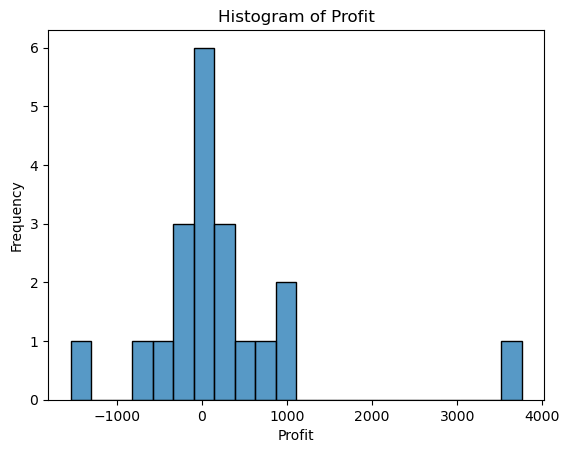

In [73]:
# Create a histogram of the 'profit' column
sns.histplot(df_gacelas['profit'], bins=22)
plt.title('Histogram of Profit')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.show()

In [90]:
import pandas as pd

# Definir los tramos de beneficios
bins = [-1800, -1500, -1000, -600, -400, -200, 0, 200, 400, 600, 1000, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900]
labels = [f'{bins[i]}--{bins[i+1]}' for i in range(len(bins)-1)]

# Suponiendo que el nombre correcto de la columna es 'profit'
df_gacelas['profit_bin'] = pd.cut(df_gacelas['profit'], bins=bins, labels=labels)

# Agrupar por 'profit_bin' y calcular el total de 'profit' y la cantidad de ocurrencias
beneficio_por_tramos = df_gacelas.groupby('profit_bin').agg(
    count=('profit', 'count'),
    total_profit=('profit', 'sum')
).reset_index()


print(beneficio_por_tramos)

      profit_bin  count  total_profit
0   -1800---1500      1       -1541.0
1   -1500---1000      0           0.0
2    -1000---600      1        -668.0
3     -600---400      0           0.0
4     -400---200      2        -639.0
5        -200--0      7        -593.0
6         0--200      3         404.0
7       200--400      1         370.0
8       400--600      1         497.0
9      600--1000      2        1761.0
10    1000--1500      1        1025.0
11    1500--1800      0           0.0
12    1800--2100      0           0.0
13    2100--2400      0           0.0
14    2400--2700      0           0.0
15    2700--3000      0           0.0
16    3000--3300      0           0.0
17    3300--3600      0           0.0
18    3600--3900      1        3755.0


In [83]:
# Definir los tramos de beneficios
bins = [-1800, -1500, -1200, -900, -600, -300, 0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900]
labels = [f'{bins[i]}--{bins[i+1]}' for i in range(len(bins)-1)]

# Crear una nueva columna para los tramos de beneficios
df_gacelas['profit_bin'] = pd.cut(df_gacelas['total_profit'], bins=bins, labels=labels)

# Agrupar por 'profit_bin' y calcular el total de 'total_profit' y la cantidad de ocurrencias
beneficio_por_tramos = df_gacelas.groupby('profit_bin').agg(
    count=('total_profit', 'count'),
    total_profit=('total_profit', 'sum')
).reset_index()

import ace_tools as tools; tools.display_dataframe_to_user(name="Beneficio por Tramos", dataframe=beneficio_por_tramos)

# Mostrar el resultado
print(beneficio_por_tramos)

KeyError: 'total_profit'

In [78]:
# Define the bins and labels
min_profit = np.floor(df_gacelas['profit'].min() / 300) * 300
max_profit = np.ceil(df_gacelas['profit'].max() / 300) * 300
bins = np.arange(min_profit, max_profit + 300, 300)
labels = [f'{int(i)}-{int(i+300)}' for i in bins[:-1]]

# Bin the data
df_gacelas['profit_bin'] = pd.cut(df_gacelas['profit'], bins=bins, labels=labels, right=False, include_lowest=True)

# Group by the bins and calculate the count and sum of profits
grouped = df_gacelas.groupby('profit_bin').agg(
    count=('profit', 'size'),
    total_profit=('profit', 'sum')
).reset_index()

grouped

,profit_bin,count,total_profit
0,-1800--1500,1,-1541.0
1,-1500--1200,0,0.0
2,-1200--900,0,0.0
3,-900--600,1,-668.0
4,-600--300,1,-364.0
5,-300-0,8,-868.0
6,0-300,3,404.0
7,300-600,2,867.0
8,600-900,1,769.0
9,900-1200,2,2017.0


In [77]:
# Calculate the rate of success
total_entries = len(df_gacelas)
positive_profit_entries = len(df_gacelas[df_gacelas['profit'] > 0])
negative_profit_entries = len(df_gacelas[df_gacelas['profit'] < 0])
zero_profit_entries = len(df_gacelas[df_gacelas['profit'] == 0])

positive_rate = (positive_profit_entries / total_entries) * 100
negative_rate = (negative_profit_entries / total_entries) * 100
zero_rate = (zero_profit_entries / total_entries) * 100

# Print the results
print(f"Total entries: {total_entries}")
print(f"Positive profit entries: {positive_profit_entries} ({positive_rate:.2f}%)")
print(f"Negative profit entries: {negative_profit_entries} ({negative_rate:.2f}%)")

Total entries: 28
Positive profit entries: 9 (32.14%)
Negative profit entries: 11 (39.29%)


In [ ]:
sdfgsd

In [ ]:
df_filtered = df[df['precio_compra_Put'].notna() & (df['tag'] == 'gacelas2')]

In [10]:
print(results)

NameError: name 'results' is not defined

In [ ]:
def fetch_option_data(df, base_url, api_key, ticker_column, expiration_str_column, option_type, strike_put_column, to_open_day_column):
    results = []
    close_prices = []
    open_prices_next_day = []
    
    for index, row in df.iterrows():
        try:
            # Extract parameters from the DataFrame row
            ticker = row[ticker_column]
            expiration_str = str(row[expiration_str_column])
            strike_put = str(row[strike_put_column])
            to_open_day = row[to_open_day_column]
            
            # Construct the full option symbol
            option_symbol = f'O:{ticker}{expiration_str}{option_type}{strike_put}'
            
            # Construct the full URL for the original day
            url = f"{base_url}/{option_symbol}/{to_open_day}?adjusted=true&apiKey={api_key}"
            print(f"URL for close price: {url}")
            
            # Make the request to the Polygon API for the original day
            response = requests.get(url)
            
            # Check the status code and response for the original day
            if response.status_code == 200:
                data = response.json()
                close_price = data.get('close', None)
                close_prices.append(close_price)
                results.append(data)
            else:
                error_message = response.json()
                print(f"Error: {response.status_code}")
                print(error_message)
                close_prices.append(None)
                results.append(error_message)
            
            # Construct the date for the next day
            next_day = pd.to_datetime(to_open_day) + pd.Timedelta(days=1)
            next_day_str = next_day.strftime('%Y-%m-%d')
            
            # Construct the full URL for the next day
            url_next_day = f"{base_url}/{option_symbol}/{next_day_str}?adjusted=true&apiKey={api_key}"
            print(f"URL for next day's open price: {url_next_day}")
            
            # Make the request to the Polygon API for the next day
            response_next_day = requests.get(url_next_day)
            
            # Check the status code and response for the next day
            if response_next_day.status_code == 200:
                data_next_day = response_next_day.json()
                open_price_next_day = data_next_day.get('open', None)
                open_prices_next_day.append(open_price_next_day)
            else:
                error_message_next_day = response_next_day.json()
                print(f"Error: {response_next_day.status_code}")
                print(error_message_next_day)
                open_prices_next_day.append(None)
        except Exception as e:
            print(f"An error occurred for row {index}: {e}")
            close_prices.append(None)
            open_prices_next_day.append(None)
            results.append({"error": str(e)})
    
    # Add the close_prices and open_prices_next_day to the DataFrame
    df['precio_compra_Put'] = close_prices
    df['precio_venta_Put'] = open_prices_next_day
    return results


In [ ]:
df

In [ ]:
# Define the base URL and API key
base_url = 'https://api.polygon.io/v1/open-close'
api_key = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'

# Define the parameters for the request
ticker = 'COST'
expiration_str = '240308'
option_type = 'P'  # Put option
strike_put = '00785000'
date = '2024-03-07'

# Construct the full option symbol
option_symbol = f'O:{ticker}{expiration_str}{option_type}{strike_price}'

# Construct the full URL
url = f"{base_url}/{option_symbol}/{date}?adjusted=true&apiKey={api_key}"
print(url)

# Make the request to the Polygon API
response = requests.get(url)

# Check the status code and response
if response.status_code == 200:
    data = response.json()
    print(data)
else:
    error_message = response.json()
    print(f"Error: {response.status_code}")
    print(error_message)

In [ ]:
# Define the base URL and API key
base_url = 'https://api.polygon.io/v1/open-close'
api_key = 'HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'

# Define the option type
option_type = 'P'  # Put option

# Fetch option data for all rows in the DataFrame
results = fetch_option_data(df, base_url, api_key, 'ticker', 'expiration_str', option_type, 'strike_put', 'to_open_day')